In [1]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

/tmp/ipykernel_35688/2723528654.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
import torch
print("Using torch", torch.__version__)

Using torch 2.1.0+cpu


In [4]:
torch.manual_seed(42) ## Setting the seed

In [5]:
x = torch.Tensor(2, 3, 4)
print(x)

tensor([[[1.5372e-42, 4.5771e-41, 6.3102e-34, 0.0000e+00],
         [1.2612e-44, 0.0000e+00, 6.3102e-34, 0.0000e+00],
         [1.5386e-42, 0.0000e+00, 6.3102e-34, 0.0000e+00]],

        [[1.2612e-44, 4.2039e-45, 6.3102e-34, 0.0000e+00],
         [1.5442e-42, 8.4078e-45, 6.3102e-34, 0.0000e+00],
         [1.2612e-44, 4.5771e-41, 6.3102e-34, 0.0000e+00]]])


In [6]:
x = torch.Tensor([[1, 2], [3, 4]])
print(x)

tensor([[1., 2.],
        [3., 4.]])


In [7]:
x = torch.rand(2, 3, 4)
print(x)

tensor([[[0.8823, 0.9150, 0.3829, 0.9593],
         [0.3904, 0.6009, 0.2566, 0.7936],
         [0.9408, 0.1332, 0.9346, 0.5936]],

        [[0.8694, 0.5677, 0.7411, 0.4294],
         [0.8854, 0.5739, 0.2666, 0.6274],
         [0.2696, 0.4414, 0.2969, 0.8317]]])


In [8]:
shape = x.shape
print("Shape:", x.shape)

size = x.size()
print("Size:", size)

dim1, dim2, dim3, = x.size()
print("Size:", dim1, dim2, dim3)

Shape: torch.Size([2, 3, 4])
Size: torch.Size([2, 3, 4])
Size: 2 3 4


In [9]:
np_arr = np.array([[1, 2], [3, 4]])
tensor = torch.from_numpy(np_arr)

print("Numpy array:", np_arr)
print("PyTorch tensor:", tensor)

Numpy array: [[1 2]
 [3 4]]
PyTorch tensor: tensor([[1, 2],
        [3, 4]])


In [10]:
tensor = torch.arange(4)
np_arr = tensor.numpy()

print("PyTorch tensor:", tensor)
print("Numpy array:", np_arr)

PyTorch tensor: tensor([0, 1, 2, 3])
Numpy array: [0 1 2 3]


## Learning by example: Continuos XOR

In [11]:
import torch.nn as nn
import torch.nn.functional as F

### nn.Module

In [12]:
class MyModule(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

In [13]:
class SimpleClassifier(nn.Module):
    
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we neef to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        
    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [14]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [15]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [16]:
# import data
import torch.utils.data as data

In [17]:
class XORDataset(data.Dataset):
    
    def __init__(self, size, std=0.1):
        """
        Inputs
        :param size: Number of data points we want to generate 
        :param std: Standard deviation of the noise (see generate_continuos_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continous_xor()
        
    def generate_continous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)
        
        self.data = data
        self.label = label
        
    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size
    
    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [18]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.1470, 0.8878]), tensor(1))


In [19]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolors="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolors="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

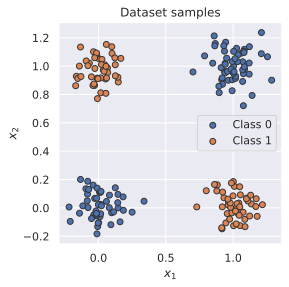

In [20]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [21]:
# The data loader class
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return, we can simply use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1, ..., d_N] where d_1, ..., d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 1.2173e+00,  2.2524e-02],
        [ 1.0626e+00,  1.0914e+00],
        [-2.7863e-02,  1.0589e+00],
        [ 9.9912e-01,  8.5048e-02],
        [-1.0164e-03,  2.3372e-02],
        [-5.1567e-02, -7.5318e-02],
        [ 8.6139e-01,  1.6513e-01],
        [ 1.1713e+00,  6.4644e-02]])
Data labels torch.Size([8]) 
 tensor([1, 0, 1, 1, 0, 0, 1, 1])


In [22]:
# Loss modules
loss_module = nn.BCEWithLogitsLoss()

In [23]:
# Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [24]:
# Training
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [25]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? False


In [26]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device", device)

Device cpu


In [27]:
# Push model to device. Has to be only done once
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [28]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            
            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()

In [29]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
# Saving a model
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-1.6544, -1.4383],
        [-0.0697, -0.5976],
        [ 2.5708, -3.0233],
        [ 3.4469, -3.1004]])), ('linear1.bias', tensor([ 0.1406,  0.7336, -1.1911,  1.4999])), ('linear2.weight', tensor([[-2.0847,  1.3582,  4.2633, -4.6693]])), ('linear2.bias', tensor([2.1530]))])


In [31]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_model.tar")

In [32]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-1.6544, -1.4383],
        [-0.0697, -0.5976],
        [ 2.5708, -3.0233],
        [ 3.4469, -3.1004]])), ('linear1.bias', tensor([ 0.1406,  0.7336, -1.1911,  1.4999])), ('linear2.weight', tensor([[-2.0847,  1.3582,  4.2633, -4.6693]])), ('linear2.bias', tensor([2.1530]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-1.6544, -1.4383],
        [-0.0697, -0.5976],
        [ 2.5708, -3.0233],
        [ 3.4469, -3.1004]])), ('linear1.bias', tensor([ 0.1406,  0.7336, -1.1911,  1.4999])), ('linear2.weight', tensor([[-2.0847,  1.3582,  4.2633, -4.6693]])), ('linear2.bias', tensor([2.1530]))])


### Evaluation

In [33]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch allthough it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [34]:
def eval_model(model, data_loader):
    model.eval()    # Set model to eval mode
    true_preds, num_preds = 0., 0.
    
    with torch.no_grad():   # Deactive the gradients for the following code
        for data_inputs, data_labels in data_loader:
            
            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)    # Sigmoid to map prediction between 0 and 1
            pred_labels = (preds >= 0.5).long()     # Binarize prediction to 0 and 1
            
            # Keep records of prediction for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [35]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


## Visulaizing classification boundaries

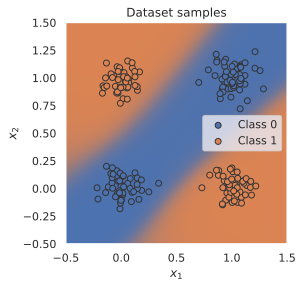

In [36]:
@torch.no_grad()    # Decorator, same effect as "with torch.no_grad(): ..." over the whole function
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()

## Additional features

### TensorBoard logging

In [38]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

# Load tensorboard extension for Jupyter Notebook, only need to start TB in the nodebook
%load_ext tensorboard

In [39]:
def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100, logging_dir='runs/our_experiment'):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False
    
    # Set model to train mode
    model.train()
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:
            
            # Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True
                
            # Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)    # Output is [Batch size, 1], but we want [Batch size]
            
            # Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            # Step 4: Perform backpropagation
            # Before calculation the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step()
            
            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()
            
        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step=epoch + 1)
        
        # Visualize prediction and add firgure to TensorBoard
        # Since matplotlib figures can be slow in rendering, we only to it every 10th epocj
        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure('predictions',
                              fig,
                              global_step=epoch+1)
    writer.close()

In [40]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model_with_logger(model, optimizer, train_data_loader, loss_module, val_dataset=dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

In [41]:
%tensorboard --logdir runs/out_experiment

Launching TensorBoard...